In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import feature_selection

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors

#import seaborn as sns
from sqlalchemy import create_engine

In [2]:
import pandas as pd
%matplotlib inline

In [3]:
#sns.set_context(font_scale=1.2)

In [4]:
font = {'family'        : 'sans-serif',
        'sans-serif'    : ['Computer Modern Sans serif'],
        'weight'        : 'regular',
        'size'          : 12}

text = {'usetex'        : False}

plt.rc('font', **font)
plt.rc('text', **text)

In [5]:
engine = create_engine('sqlite:///../RBpipeline/rbogus-dev.db')

## Load the tables from the DB

Using a merge we can get the detected portion of the objects, with the
recovered data, and the correct simulated data.

In [6]:
dt_zps = pd.merge(pd.read_sql_table('Detected', engine),
                  pd.read_sql_query("""SELECT 
                                        Detected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.r_scales as r_scales,
                                        Simulated.gx_mag as gx_mag,
                                        Simulated.id as sim_id 
                                    FROM Detected
                                        LEFT JOIN Reals
                                            ON Detected.id==Reals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==Reals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_ois = pd.merge(pd.read_sql_table('DetectedOIS', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedOIS.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.r_scales as r_scales,
                                        Simulated.gx_mag as gx_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedOIS
                                        LEFT JOIN RealsOIS
                                            ON DetectedOIS.id==RealsOIS.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsOIS.simulated_id""", engine),
                                      on='id', suffixes=('',''))

dt_hot = pd.merge(pd.read_sql_table('DetectedHOT', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedHOT.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.r_scales as r_scales,
                                        Simulated.gx_mag as gx_mag, 
                                        Simulated.id as sim_id 
                                    FROM DetectedHOT
                                        LEFT JOIN RealsHOT
                                            ON DetectedHOT.id==RealsHOT.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsHOT.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [7]:
dt_zps.describe()

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,DELTAX,DELTAY,RATIO,ROUNDNESS,PEAK_CENTROID,image_id,sim_mag,r_scales,gx_mag,sim_id
count,60838.000000,60838.000000,60838.000000,60838.000000,60838.000000,60838.000000,60838.000000,60838.000000,60838.000000,60838.000000,...,60838.000000,60838.000000,60838.000000,60838.000000,60838.000000,60838.000000,45445.000000,45445.000000,45445.000000,45445.000000
mean,30419.500000,25.957773,362.700488,5.416779,20.116988,0.081562,202.112139,4.357855,20.628428,0.491712,...,5.839853,5.778165,0.808650,1.443943,0.608369,627.849929,21.008121,1.628889,21.754073,60980.653625
std,17562.562175,16.115625,2244.452429,2.666962,1.469681,0.055824,773.135811,0.058155,5.069142,6.312451,...,3.881927,3.997493,0.194586,0.724280,0.595989,360.744801,1.228685,2.129935,1.402609,35179.566962
min,1.000000,1.000000,5.599610,2.131438,11.206900,0.000300,-452.720700,3.445639,14.411200,0.000300,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,10.115349,0.000000,11.598300,2.000000
25%,15210.250000,13.000000,33.546545,3.547334,19.299800,0.037100,34.611780,4.340186,19.800400,0.039400,...,3.000000,3.000000,0.692308,1.096357,0.334183,315.000000,20.428750,0.333488,20.902200,30491.000000
50%,30419.500000,25.000000,74.472030,4.866858,20.320000,0.070700,57.037830,4.368384,20.609600,0.083000,...,5.000000,5.000000,0.833333,1.216632,0.490440,628.000000,21.307909,1.007913,22.020500,60914.000000
75%,45628.750000,37.000000,190.579275,6.610301,21.185900,0.116400,120.180800,4.387406,21.151900,0.136700,...,7.000000,7.000000,1.000000,1.560000,0.707094,941.000000,21.880649,2.219603,22.854500,91467.000000
max,60838.000000,100.000000,329031.000000,87.570880,23.129600,0.470900,17199.450000,4.439630,99.000000,290.210300,...,118.000000,190.000000,1.000000,51.474545,44.688264,1250.000000,23.919734,96.382014,24.956000,121901.000000


In [8]:
dt_ois.describe()

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,DELTAX,DELTAY,RATIO,ROUNDNESS,PEAK_CENTROID,image_id,sim_mag,r_scales,gx_mag,sim_id
count,132961.000000,132961.000000,1.329610e+05,132961.000000,132961.000000,132961.000000,1.329610e+05,132961.000000,132961.000000,132961.000000,...,132961.000000,132961.000000,132961.000000,132961.000000,132961.000000,132961.000000,56239.000000,56239.000000,56239.000000,56239.000000
mean,66481.000000,65.814066,1.371303e+04,262.779828,16.114271,0.095947,9.073974e+03,257.350996,16.313783,0.282821,...,5.126120,5.043750,0.728122,1.904130,0.866236,622.394228,21.323487,1.542560,21.956892,60856.987820
std,38382.678908,58.143277,1.049150e+05,149.978830,1.371549,0.061533,4.215816e+04,34.037616,3.550438,4.035236,...,13.279789,12.236538,0.271740,4.354811,4.498241,359.521386,1.303295,2.022798,1.372801,35185.534946
min,1.000000,1.000000,4.044632e+02,97.455400,6.540100,0.000200,-1.998272e+04,175.813300,9.766000,0.000200,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,10.115349,0.000000,11.598300,2.000000
25%,33241.000000,27.000000,1.361234e+03,170.224600,15.381700,0.047200,1.665712e+03,243.839200,15.695900,0.052600,...,2.000000,2.000000,0.500000,1.127511,0.331798,313.000000,20.693529,0.309647,21.163700,30335.500000
50%,66481.000000,54.000000,2.933114e+03,227.177200,16.331700,0.083600,2.535737e+03,250.063100,16.489700,0.108800,...,4.000000,4.000000,0.800000,1.321831,0.474467,616.000000,21.576900,0.936533,22.257600,60933.000000
75%,99721.000000,85.000000,7.036111e+03,312.312000,17.165200,0.139300,5.267862e+03,262.546900,16.946000,0.170500,...,6.000000,6.000000,1.000000,1.689732,0.685814,930.000000,22.254677,2.098544,22.996000,91250.500000
max,132961.000000,602.000000,2.420808e+07,6663.749000,18.482800,0.341700,1.240464e+06,453.669100,99.000000,99.000000,...,1023.000000,1019.000000,1.000000,577.622889,530.160445,1250.000000,26.673668,96.382014,25.246000,121901.000000


In [9]:
dt_hot.describe()

,id,NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,FLUX_APER,FLUXERR_APER,MAG_APER,MAGERR_APER,...,DELTAX,DELTAY,RATIO,ROUNDNESS,PEAK_CENTROID,image_id,sim_mag,r_scales,gx_mag,sim_id
count,292921.000000,292921.000000,2.929210e+05,2.929210e+05,292921.000000,292921.000000,2.929210e+05,2.929210e+05,292921.000000,292921.000000,...,292921.000000,292921.000000,292921.000000,292921.000000,292921.000000,292921.000000,48968.000000,48968.000000,48968.000000,48968.000000
mean,146461.000000,1047.787871,1.202645e+05,7.072579e+03,16.257868,0.108362,3.045912e+04,1.035503e+04,17.736664,1.779476,...,4.260302,4.605610,0.668410,1.997925,0.898702,598.576015,21.288235,1.552772,21.940460,61161.309692
std,84559.153438,1376.514721,2.053828e+06,7.892802e+04,1.417623,0.052535,4.676754e+05,1.098284e+05,9.748077,58.358310,...,4.305501,5.132799,0.240851,0.905557,1.891389,347.286139,1.226359,1.928309,1.330986,35314.390904
min,1.000000,1.000000,3.329309e+02,8.730269e+01,3.239100,0.000600,-1.122447e+07,1.679034e+02,5.388100,0.001000,...,0.000000,0.000000,0.000000,1.000000,0.000141,1.000000,10.115349,0.000000,11.598300,5.000000
25%,73231.000000,69.000000,1.304003e+03,1.656443e+02,15.642600,0.069800,1.259363e+03,2.551081e+02,16.173600,0.120000,...,2.000000,2.000000,0.500000,1.377150,0.362966,290.000000,20.650237,0.320797,21.123175,30482.500000
50%,146461.000000,470.000000,2.508009e+03,2.322327e+02,16.501700,0.102800,1.790087e+03,2.844218e+02,16.867800,0.185200,...,3.000000,3.000000,0.666667,1.698376,0.497494,588.000000,21.511700,0.960278,22.215500,61472.500000
75%,219691.000000,1499.000000,5.533042e+03,3.436409e+02,17.211800,0.143500,3.392847e+03,3.882907e+02,17.249600,0.253700,...,5.000000,5.000000,0.888889,2.381601,0.819884,870.000000,22.168108,2.133876,22.966100,91821.250000
max,292921.000000,7986.000000,5.062365e+08,5.212348e+06,18.694100,0.418200,6.994360e+07,1.222395e+06,99.000000,30787.595700,...,267.000000,423.000000,1.000000,11.989619,100.896133,1250.000000,25.283541,96.382014,25.042000,121900.000000


In [10]:
dt_ois.IS_REAL = dt_ois.IS_REAL.astype(int)
dt_zps.IS_REAL = dt_zps.IS_REAL.astype(int)
dt_hot.IS_REAL = dt_hot.IS_REAL.astype(int)

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


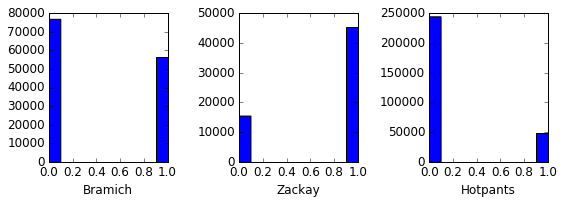

In [11]:
plt.figure(figsize=(8,3))
plt.subplot(131)
plt.hist(dt_ois['IS_REAL'])
plt.xlabel('Bramich')
plt.subplot(132)
plt.hist(dt_zps['IS_REAL'])
plt.xlabel('Zackay')
plt.subplot(133)
plt.hist(dt_hot['IS_REAL'])
plt.xlabel('Hotpants')
plt.tight_layout()

In [12]:
dt_ois.columns

Index([u'id', u'NUMBER', u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'XMIN_IMAGE',
       u'YMIN_IMAGE', u'XMAX_IMAGE', u'YMAX_IMAGE', u'XPEAK_IMAGE',
       u'YPEAK_IMAGE', u'X_IMAGE', u'Y_IMAGE', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID', u'IS_REAL', u'image_id',
       u'sim_mag', u'r_scales', u'gx_mag', u'sim_id'],
      dtype='object')

## Select the columns 

We select for both methods the columns related to every detection recovered data. 

There are 35 columns relevant, and this would be the biggest features set for training and testing.
Also we perform a random sampling, to be ablo tohandle the data

In [13]:
dt_zps = dt_zps.sample(20000)
dt_ois = dt_ois.sample(20000)
dt_hot = dt_hot.sample(20000)

In [14]:
d_ois = dt_ois[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID']]

In [15]:
d_zps = dt_zps[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID']]

In [16]:
d_hot = dt_hot[[ u'FLUX_ISO', u'FLUXERR_ISO', u'MAG_ISO',
       u'MAGERR_ISO', u'FLUX_APER', u'FLUXERR_APER', u'MAG_APER',
       u'MAGERR_APER', u'FLUX_AUTO', u'FLUXERR_AUTO', u'MAG_AUTO',
       u'MAGERR_AUTO', u'BACKGROUND', u'THRESHOLD', u'FLUX_MAX', u'X2_IMAGE', u'Y2_IMAGE',
       u'XY_IMAGE', u'CXX_IMAGE', u'CYY_IMAGE', u'CXY_IMAGE', u'A_IMAGE',
       u'B_IMAGE', u'THETA_IMAGE', u'MU_MAX', u'FLAGS', u'FWHM_IMAGE',
       u'ELONGATION', u'ELLIPTICITY', u'CLASS_STAR', u'DELTAX', u'DELTAY',
       u'RATIO', u'ROUNDNESS', u'PEAK_CENTROID']]

In [17]:
len(d_zps.columns)

35

### Preprocesing
If we convert this to matrix (numpy arrays) we can then *preprocess* this data to become Machine treatable.

### Scaled

This scaling process transforms data to match distributions with zero mean and unit variance.

In [18]:
X_zps = d_zps.as_matrix()
X_ois = d_ois.as_matrix()
X_hot = d_hot.as_matrix()

In [19]:
scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)

In [20]:
X_ois_scaled = scaler_ois.transform(X_ois)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)

# Feature selection

Choosing a ranker
-----------------

It is important to know that feature selection is a general term for tossing the descriptors that doesn't work
as expected. This is not always mentioned, but in general one firstly should decide which ML algorithm will use,
for example a support vector machines. So, select a feature should be introduced tied to the algorithm applied for selection and perfomance testing. 

If it is not like this, one could provide misleading information, like jumping to the conclusion that there is no relation at all between a poor performer feature and the objective class, since the method for ML may be somehow not able to grab the information the feature provides. 

A quick notion of this is the non-linearities present in the profound behaviour of the reality, that we want to learn using linear kernels in a Support VM algorithm.

In [21]:
Y_ois = dt_ois['IS_REAL']
Y_zps = dt_zps['IS_REAL']
Y_hot = dt_hot['IS_REAL']

In [22]:
fraction_reals_ois = sum(Y_ois)/float(len(Y_ois))
fraction_bogus_ois = 1. - fraction_reals_ois

In [23]:
print 'The fraction of reals is: {}'.format(fraction_reals_ois)
print 'The fraction of bogus is: {}'.format(fraction_bogus_ois)
print '\n'
print 'The ratio is: {}'.format(fraction_reals_ois/fraction_bogus_ois)

The fraction of reals is: 0.4209
The fraction of bogus is: 0.5791


The ratio is: 0.726817475393


In [24]:
fraction_reals_zps = sum(Y_zps)/float(len(Y_zps))
fraction_bogus_zps = 1. - fraction_reals_zps

In [25]:
print 'The fraction of reals is: {}'.format(fraction_reals_zps)
print 'The fraction of bogus is: {}'.format(fraction_bogus_zps)
print '\n'
print 'The ratio is: {}'.format(fraction_reals_zps/fraction_bogus_zps)

The fraction of reals is: 0.747
The fraction of bogus is: 0.253


The ratio is: 2.95256916996


In [26]:
fraction_reals_hot = sum(Y_hot)/float(len(Y_hot))
fraction_bogus_hot = 1. - fraction_reals_hot

In [27]:
print 'The fraction of reals is: {}'.format(fraction_reals_hot)
print 'The fraction of bogus is: {}'.format(fraction_bogus_hot)
print '\n'
print 'The ratio is: {}'.format(fraction_reals_hot/fraction_bogus_hot)

The fraction of reals is: 0.1661
The fraction of bogus is: 0.8339


The ratio is: 0.199184554503


### Univariate selection (*f-test* + *SelectPercentile*)

In [28]:
from sklearn.feature_selection import SelectPercentile, f_classif

In [29]:
percentile = 30.

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or 

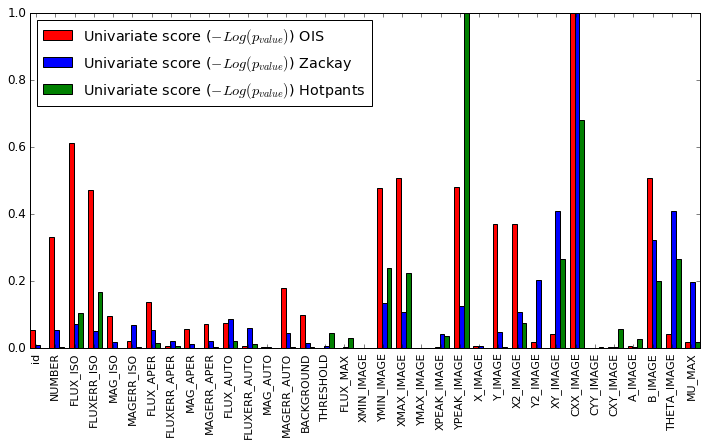

In [30]:
plt.figure(figsize=(12, 6))
#plt.subplot(131)
selector = SelectPercentile(f_classif, percentile=percentile)
selector.fit(X_ois_scaled, Y_ois)
scores = selector.scores_ #-np.log10(selector.pvalues_)
scores /= scores.max()

ois_selected_cols = selector.transform(np.arange(X_ois_scaled.shape[-1]))

plt.bar(np.arange(X_ois_scaled.shape[-1]), scores, width=.25,
        label=r'Univariate score ($-Log(p_{value})$) OIS', color='red')
plt.xticks(np.arange(X_ois_scaled.shape[-1])+0.3, dt_ois.columns, rotation='vertical', fontsize=11)
#plt.title('OIS')

#plt.subplot(132)
selector = SelectPercentile(f_classif, percentile=percentile)
selector.fit(X_zps_scaled, Y_zps)
scores = selector.scores_ #-np.log10(selector.pvalues_)
scores /= scores.max()

zps_selected_cols = selector.transform(np.arange(X_zps_scaled.shape[-1]))

plt.bar(np.arange(X_zps_scaled.shape[-1])+0.25, scores, width=.25,
        label=r'Univariate score ($-Log(p_{value})$) Zackay', color='blue')
#plt.xticks(np.arange(X_zps_scaled.shape[-1]), dt_zps.columns, rotation='vertical', fontsize=9)
#plt.title('Zackay')

#plt.subplot(133)
selector = SelectPercentile(f_classif, percentile=percentile)
selector.fit(X_hot_scaled, Y_hot)
scores = selector.scores_ #-np.log10(selector.pvalues_)
scores /= scores.max()

hot_selected_cols = selector.transform(np.arange(X_hot_scaled.shape[-1]))

plt.bar(np.arange(X_hot_scaled.shape[-1])+0.5, scores, width=.25,
        label=r'Univariate score ($-Log(p_{value})$) Hotpants', color='green')
#plt.xticks(np.arange(X_hot_scaled.shape[-1]), dt_hot.columns, rotation='vertical', fontsize=9)
#plt.title('Hotpants')
plt.legend(loc='best')

plt.show()

### Scaled

This scaling process transforms data to match distributions with zero mean and unit variance.

In [31]:
d_zps = d_zps[d_zps.columns[zps_selected_cols][0]]
d_ois = d_ois[d_ois.columns[ois_selected_cols][0]]
d_hot = d_hot[d_hot.columns[hot_selected_cols][0]]

In [32]:
X_zps = d_zps.as_matrix()
X_ois = d_ois.as_matrix()
X_hot = d_hot.as_matrix()

In [33]:
scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)

In [34]:
X_ois_scaled = scaler_ois.transform(X_ois)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)

**Recursive feature elimination**

This a feature selection technique, that is completely supervised (in opposition to a Principal Component Analisys), and aims to elminate features that have poor description power in the chosen model environment.

For example in the code block below, we use a *c45* decision tree, and a *step* value of 3. This means, that we will train a *c45* algorithm tossing three random features, repeteadly, until we get a notion of which set of features get better scores (*f1* in this case). We repeat this using a 10 fold cross validation, and then decide which features we eliminate.

So it is a recursive technique that depends strongly on the *c45* election. It is clear that features that perform poor on a decision tree can be good descriptors for SVM for example. 

### OIS

In [35]:
svc = SVC(kernel='linear', 
          cache_size=600, 
          class_weight='balanced', 
          probability=False)

In [36]:
rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=StratifiedKFold(6),
              scoring='f1', n_jobs=7)
%time rfecv.fit(np.ascontiguousarray(X_ois_scaled), Y_ois)

CPU times: user 37.8 s, sys: 1.19 s, total: 39 s
Wall time: 4min


RFECV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
   estimator=SVC(C=1.0, cache_size=600, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=7, scoring='f1', step=1, verbose=0)

In [37]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 9


In [38]:
d_ois.columns[rfecv.support_]

Index([u'MAG_ISO', u'MAGERR_ISO', u'THRESHOLD', u'CXX_IMAGE', u'CYY_IMAGE',
       u'MU_MAX', u'FLAGS', u'ELLIPTICITY', u'RATIO'],
      dtype='object')

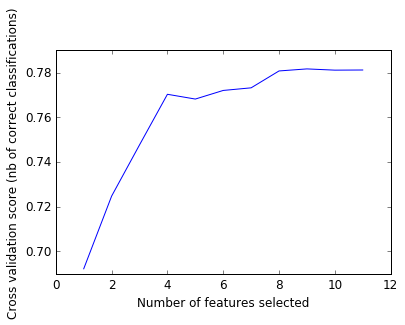

In [39]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [40]:
dB = d_ois[d_ois.columns[rfecv.support_]]

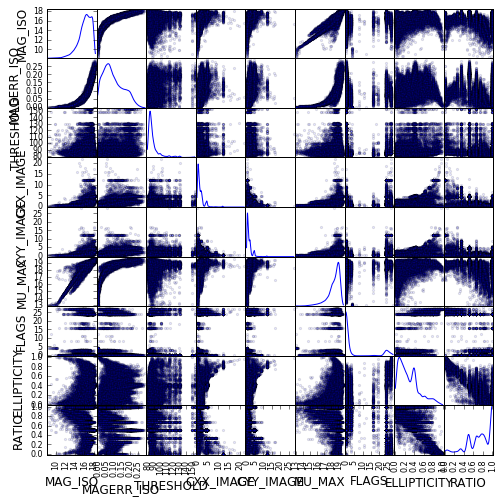

In [41]:
if rfecv.n_features_< 10:
    pd.scatter_matrix(dB, alpha=0.1, figsize=(8, 8), diagonal='kde')
    plt.show()

### Zackay

In [42]:
svc = SVC(kernel='linear', 
          cache_size=600, 
          class_weight='balanced', 
          probability=False)

In [43]:
c45 = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=33)

In [44]:
rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=StratifiedKFold(6),
              scoring='f1', n_jobs=7)

In [45]:
rfecv.fit(np.ascontiguousarray(X_zps_scaled), Y_zps)

RFECV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
   estimator=SVC(C=1.0, cache_size=600, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=7, scoring='f1', step=1, verbose=0)

In [46]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 8


In [47]:
d_zps.columns[rfecv.support_]

Index([u'MAG_AUTO', u'CXX_IMAGE', u'CYY_IMAGE', u'B_IMAGE', u'FLAGS',
       u'FWHM_IMAGE', u'ELLIPTICITY', u'PEAK_CENTROID'],
      dtype='object')

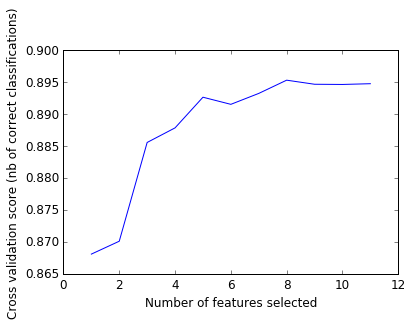

In [48]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [49]:
dZ = d_zps[d_zps.columns[rfecv.support_]]

In [50]:
if sum(rfecv.support_)< 7:
    pd.scatter_matrix(dZ, alpha=0.1, figsize=(10, 10), diagonal='kde')
    plt.grid()
    plt.show()

### HOTPANTS

In [51]:
c45 = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=33)

In [52]:
svc = SVC(kernel='linear', 
          cache_size=600, 
          class_weight='balanced', 
          probability=False)

In [53]:
rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=StratifiedKFold(6),
              scoring='f1', n_jobs=7)

In [54]:
%time rfecv.fit(np.ascontiguousarray(X_hot_scaled), Y_hot)

CPU times: user 35.7 s, sys: 3.58 s, total: 39.3 s
Wall time: 1min 26s


RFECV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
   estimator=SVC(C=1.0, cache_size=600, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=7, scoring='f1', step=1, verbose=0)

In [55]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 3


In [56]:
d_hot.columns[rfecv.support_]

Index([u'MAG_ISO', u'B_IMAGE', u'FLAGS'], dtype='object')

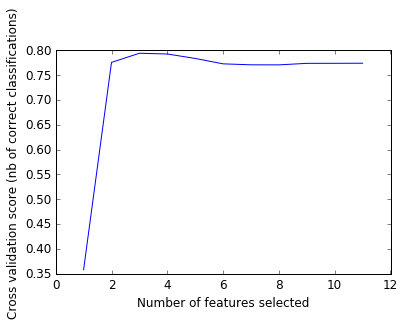

In [57]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [58]:
dH = d_hot[d_hot.columns[rfecv.support_]]

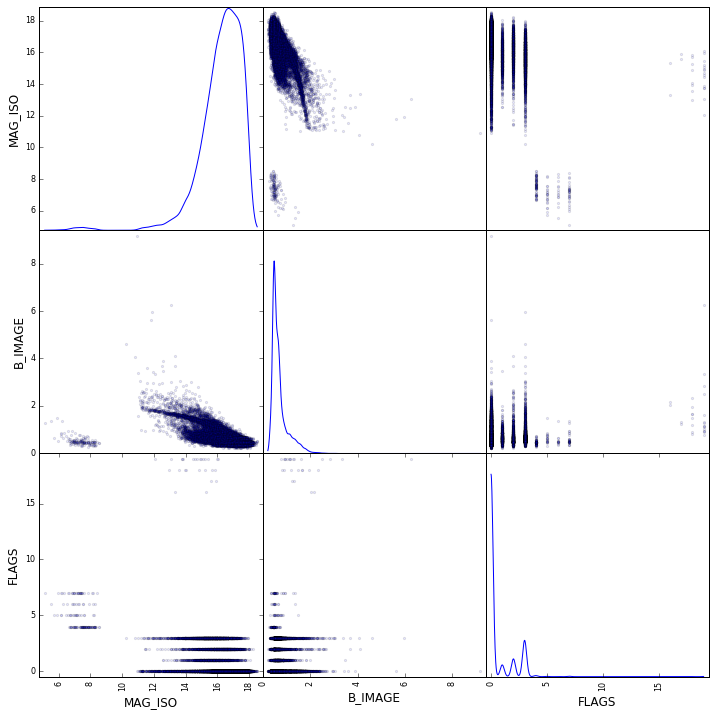

In [59]:
if rfecv.n_features_ < 7:
    pd.scatter_matrix(dH, alpha=0.1, figsize=(12, 12), diagonal='kde')
    plt.show()

## Post processing

Repeat the scaling pre processing so we get the selected features normalized

In [60]:
X_zps = dZ.as_matrix()
X_ois = dB.as_matrix()
X_hot = dH.as_matrix()

scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)

X_ois_scaled = scaler_ois.transform(X_ois)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)

## Univariate feature selection

### ANOVA

In [61]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

transform = SelectPercentile(f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0, 
                                                      cache_size=500, 
                                                      class_weight='balanced') )])

In [62]:
def anova_svm(X, y, clf, title=None):
    score_means = list()
    score_stds = list()
    percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

    for percentile in percentiles:
        clf.set_params(anova__percentile=percentile)
        # Compute cross-validation score using 1 CPU
        this_scores = cross_val_score(clf, X, y, n_jobs=4)
        score_means.append(this_scores.mean())
        score_stds.append(this_scores.std())

    plt.errorbar(percentiles, score_means, np.array(score_stds))

    if title is None:
        plt.title(
            'Performance of the SVM-Anova varying the percentile of features selected')
    else:
        plt.title(title)
    plt.xlabel('Percentile')
    plt.ylabel('Prediction rate')

    plt.axis('tight')
    #plt.show()

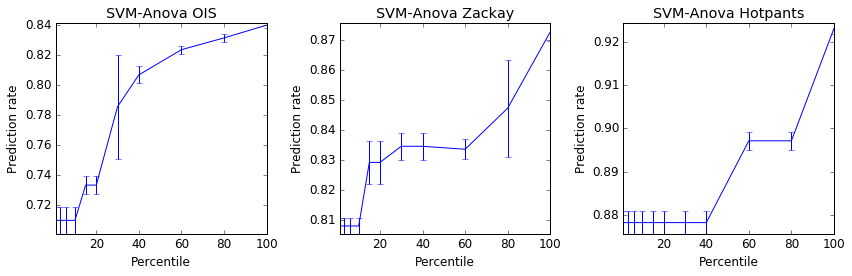

In [63]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
anova_svm(np.ascontiguousarray(X_ois_scaled), Y_ois, clf, title='SVM-Anova OIS')
plt.subplot(132)
anova_svm(np.ascontiguousarray(X_zps_scaled), Y_zps, clf, title='SVM-Anova Zackay')
plt.subplot(133)
anova_svm(np.ascontiguousarray(X_hot_scaled), Y_hot, clf, title='SVM-Anova Hotpants')
plt.tight_layout()
plt.show()

### Feature importance by random forest


In [64]:
from sklearn.ensemble import ExtraTreesClassifier

In [65]:
def importance_forest(X, y, forest, cols=None, method=None):
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    if cols is not None:
        for f in range(X.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, cols[indices[f]-1], importances[indices[f]]))
    else:
        for f in range(X.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    #plt.figure(figsize=(6, 6))
    plt.title("Feature importances {}".format(method))
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    if cols is not None:
        plt.xticks(range(X.shape[1]), cols[indices-1], rotation='vertical', fontsize=10)
    else:
        plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    #plt.show()
    return [(cols[indices[f]-1], importances[indices[f]]) for f in range(X.shape[1])]

Feature ranking:
1. feature THRESHOLD (0.158913)
2. feature CXX_IMAGE (0.157479)
3. feature FLAGS (0.152584)
4. feature MAG_ISO (0.104872)
5. feature RATIO (0.100606)
6. feature CYY_IMAGE (0.091364)
7. feature MAGERR_ISO (0.084057)
8. feature MU_MAX (0.081786)
9. feature ELLIPTICITY (0.068339)
Feature ranking:
1. feature FWHM_IMAGE (0.297082)
2. feature B_IMAGE (0.132605)
3. feature FLAGS (0.118098)
4. feature PEAK_CENTROID (0.109790)
5. feature CYY_IMAGE (0.090839)
6. feature MAG_AUTO (0.086676)
7. feature ELLIPTICITY (0.082977)
8. feature CXX_IMAGE (0.081934)
Feature ranking:
1. feature MAG_ISO (0.618866)
2. feature FLAGS (0.267596)
3. feature B_IMAGE (0.113538)


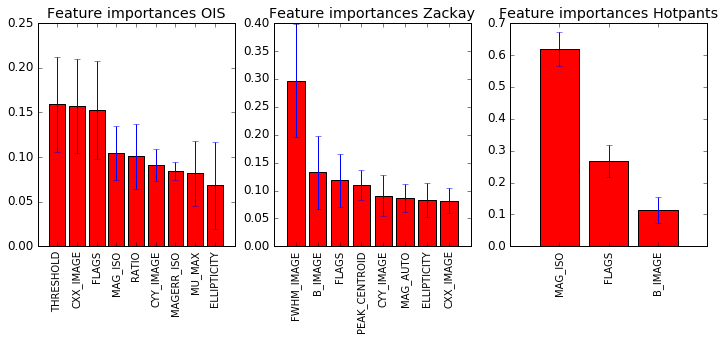

In [66]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
ois_importance = importance_forest(X_ois_scaled, Y_ois, ExtraTreesClassifier(n_estimators=250, random_state=0), 
                 cols=dB.columns, method='OIS')
plt.subplot(132)
zps_importance = importance_forest(X_zps_scaled, Y_zps, ExtraTreesClassifier(n_estimators=250, random_state=0), 
                                   cols=dZ.columns, method='Zackay')
plt.subplot(133)
hot_importance = importance_forest(X_hot_scaled, Y_hot, ExtraTreesClassifier(n_estimators=250, random_state=0), 
                                   cols=dH.columns, method='Hotpants')

In [67]:
acum=0
feats = []
for feat, imp in ois_importance:
    acum += imp
    feats.append(feat)
    if acum > .90: break

print acum, feats

0.93166091738 ['THRESHOLD', 'CXX_IMAGE', 'FLAGS', 'MAG_ISO', 'RATIO', 'CYY_IMAGE', 'MAGERR_ISO', 'MU_MAX']


In [68]:
dB = dB[feats]

In [69]:
acum=0
feats = []
for feat, imp in zps_importance:
    acum += imp
    feats.append(feat)
    if acum > .90: break

print acum, feats

0.918066036706 ['FWHM_IMAGE', 'B_IMAGE', 'FLAGS', 'PEAK_CENTROID', 'CYY_IMAGE', 'MAG_AUTO', 'ELLIPTICITY']


In [70]:
dZ = dZ[feats]

In [71]:
acum=0
feats = []
for feat, imp in hot_importance:
    acum += imp
    feats.append(feat)
    if acum > .90: break

print acum, feats

1.0 ['MAG_ISO', 'FLAGS', 'B_IMAGE']


In [72]:
dH = dH[feats]

### Principal Component Analysis

In [73]:
X_zps = dZ.as_matrix()
X_ois = dB.as_matrix()
X_hot = dH.as_matrix()

scaler_ois = preprocessing.StandardScaler().fit(X_ois)
scaler_zps = preprocessing.StandardScaler().fit(X_zps)
scaler_hot = preprocessing.StandardScaler().fit(X_hot)

X_ois_scaled = scaler_ois.transform(X_ois)
X_zps_scaled = scaler_zps.transform(X_zps)
X_hot_scaled = scaler_hot.transform(X_hot)

**OIS**

In [74]:
pca = decomposition.PCA(svd_solver='randomized', n_components=min(X_ois_scaled.shape[-1], 6))

pca.fit(X_ois_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

In [75]:
X_ois_t = pca.transform(X_ois_scaled)

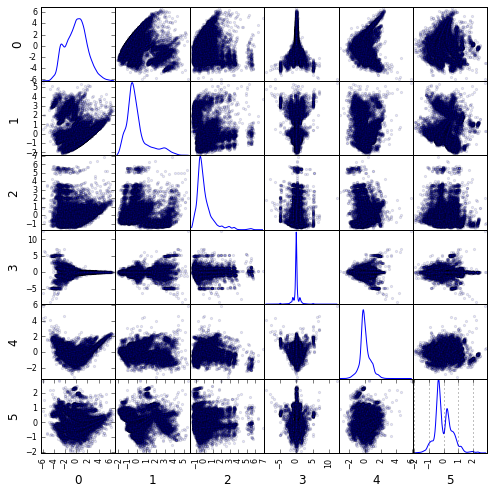

In [76]:
pd.scatter_matrix(pd.DataFrame(X_ois_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.grid()
plt.show()

**Zackay**

In [77]:
pca = decomposition.PCA(svd_solver='randomized', n_components=min(X_zps_scaled.shape[-1], 6))

pca.fit(X_zps_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

In [78]:
X_zps_t = pca.transform(X_zps_scaled)

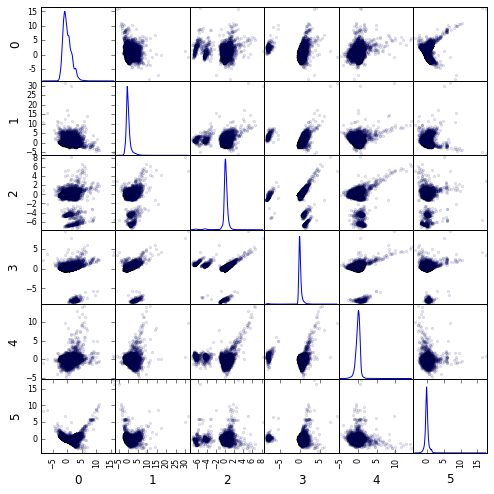

In [79]:
pd.scatter_matrix(pd.DataFrame(X_zps_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.show()

**HOTPANTS**

In [80]:
pca = decomposition.PCA(svd_solver='randomized', n_components=min(X_hot_scaled.shape[-1], 6))

pca.fit(X_hot_scaled)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

In [81]:
X_hot_t = pca.transform(X_hot_scaled)

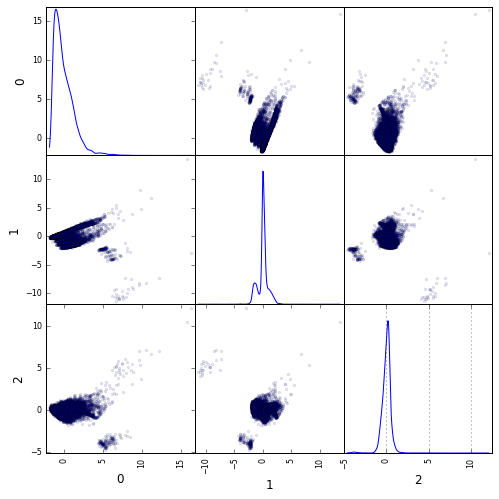

In [82]:
pd.scatter_matrix(pd.DataFrame(X_hot_t), alpha=0.1, figsize=(8, 8), diagonal='kde')
plt.grid()
plt.show()

# Machine Learning perfomance comparison

## Comparing methods algorithm to algorithm

In [83]:
def experiment(clf, x, y, nfolds=10, printing=False):
    skf = StratifiedKFold(n_splits=nfolds)
    probabilities = np.array([])
    predictions = np.array([])
    y_testing = np.array([])
    
    for train, test in skf.split(x, y):
        
        x_train = x[train]
        y_train = y[train]
        clf.fit(x_train, y_train)

        x_test = x[test]
        y_test = y[test]
        pr = clf.predict(x_test)
        probs = clf.predict_proba(x_test)[:, 0]

        probabilities = np.hstack([probabilities, probs])
        predictions = np.hstack([predictions, pr])
        y_testing = np.hstack([y_testing, y_test])

    if printing: 
        print metrics.classification_report(y_testing, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_testing, 1.-probabilities)
    prec_rec_curve = metrics.precision_recall_curve(y_testing, 1.- probabilities)
    roc_auc = metrics.auc(fpr, tpr)
    return {'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'prec_rec_curve': prec_rec_curve,
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions),
            }

### K-Nearest Neighbors


**OIS**

In [84]:
rslts_knn_ois_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [85]:
rslts_knn_zps_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [86]:
rslts_knn_hot_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_hot_scaled, Y_hot.as_matrix())

### Support vector machines

**OIS**

In [87]:
rslts_ois_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [88]:
rslts_zps_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [89]:
rslts_hot_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_hot_scaled, Y_hot.as_matrix())

### Decision tree (gini)

**OIS**

In [90]:
rslts_ois_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [91]:
rslts_zps_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [92]:
rslts_hot_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_hot_scaled, Y_hot.as_matrix())

### Random forest

**OIS**

In [93]:
rslts_ois_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [94]:
rslts_zps_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [95]:
rslts_hot_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_hot_scaled, Y_hot.as_matrix())

### DecisionTreeClassifier (C45)

**OIS**

In [96]:
rslts_ois_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_ois_scaled, Y_ois.as_matrix())

**Zackay**

In [97]:
rslts_zps_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_zps_scaled, Y_zps.as_matrix())

**Hotpants**

In [98]:
rslts_hot_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_hot_scaled, Y_hot.as_matrix())

### ROC curve

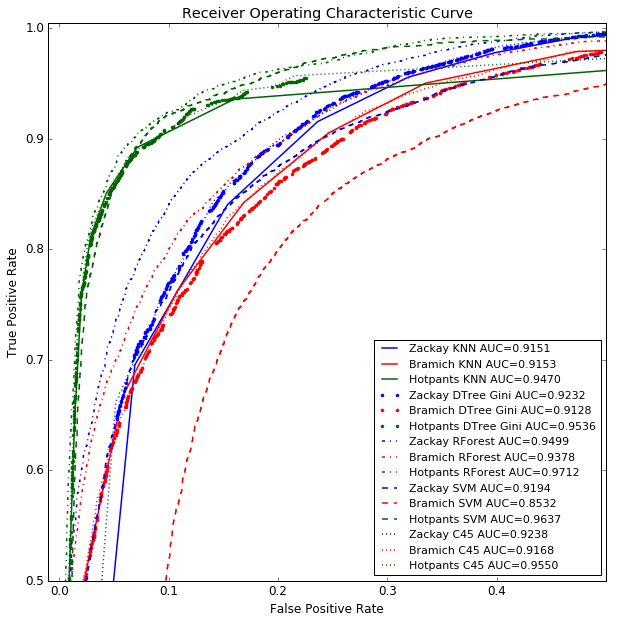

In [99]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sub_methods = [zky, bch, hot]

colors = ['blue', 'red', 'darkgreen']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest],
              'DTree Gini': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform]}


ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(10, 10))
for k, v in ml_methods.iteritems():
    for i in range(3):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        roc_auc = sub_method['roc_auc']
        sub_meth_col.append(roc_auc)
        
        label = sub_meth_col[0]+' '+k+' AUC={:06.4f}'.format(roc_auc)
        plt.plot(fpr, tpr, ls[j], lw=1.5, color=colors[i], label=label)
    j+=1

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=11)
plt.title('Receiver Operating Characteristic Curve')

plt.xlim([-0.01, 0.50])
plt.ylim([0.5, 1.005])
plt.savefig('roc_without_pca.png')

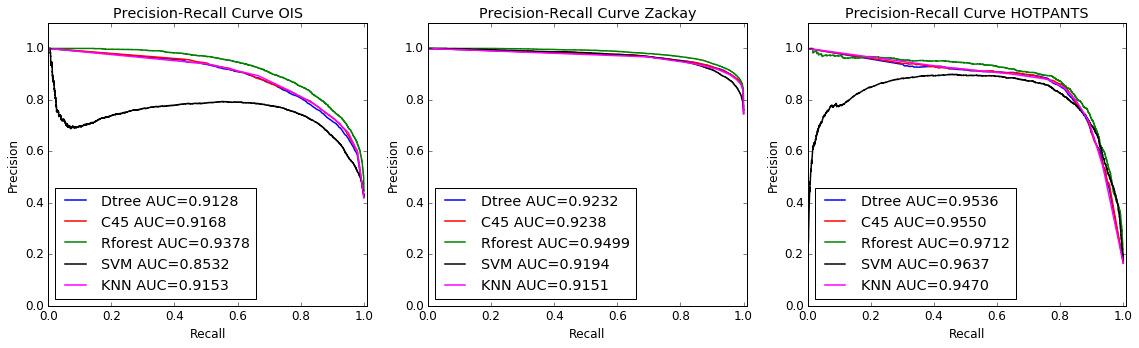

In [100]:
plt.figure(figsize=(16, 5))
#plt.figaspect(.8)
plt.subplot(131)
res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve OIS')

plt.subplot(132)
res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))
0
pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve Zackay')


plt.subplot(133)
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve HOTPANTS')

plt.tight_layout()

plt.savefig('prec_rec_without_pca.png')

In [101]:
-

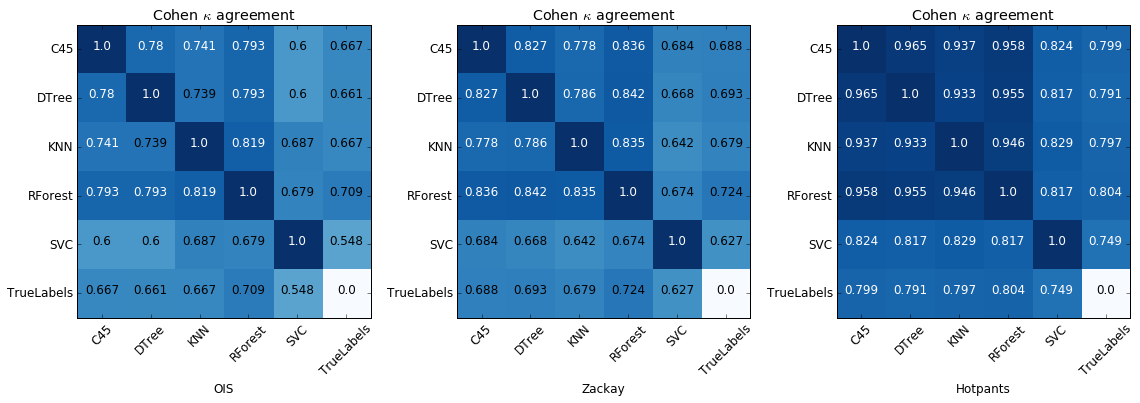

In [102]:
m_coll = []

res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])

res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
 
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
names = ['OIS', 'Zackay', 'Hotpants']

plt.figure(figsize=(16, 6))
for k, methods in enumerate(m_coll):
    kappa_agreement = np.ones((len(methods), len(methods)))

    for i in range(len(methods)):
        for j in range(i+1):
            kappa_agreement[i, j] = metrics.cohen_kappa_score(methods[i]['predictions'],
                                                              methods[j]['predictions'])#, 
                                                              #labels=['star', 'galaxy'])
            kappa_agreement[j, i] = kappa_agreement[i, j]
    kappa_agreement[-1, -1] = 0
    plt.subplot(1, 3, k+1)
    
    plot_confusion_matrix(np.round(kappa_agreement, 3), 
                          classes=['C45', 'DTree', 'KNN', 'RForest', 'SVC', 'TrueLabels'],
                          title=r'Cohen $\kappa$ agreement')
    #plt.tight_layout()
    plt.xlabel(names[k])
    plt.ylabel('')


plt.savefig('cohen_without_pca.png')

In [103]:
aucs = pd.DataFrame([zky, bch, hot], columns=['SubMethod','DTreeGini', 'C45', 'RandomForest', 'KNN', 'SVM'], )

In [104]:
AUCTable = aucs.set_index(['SubMethod'])

In [105]:
AUCTable

,DTreeGini,C45,RandomForest,KNN,SVM
SubMethod,,,,,
Zackay,0.915086,0.923166,0.949877,0.919446,0.923762
Bramich,0.915347,0.912778,0.937783,0.853190,0.916762
Hotpants,0.947040,0.953597,0.971231,0.963719,0.954964


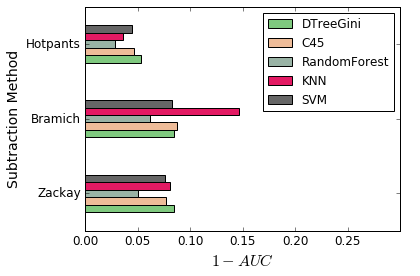

In [106]:
(1-AUCTable).plot.barh(log=False, cmap='Accent')
plt.xlabel(r'$1-AUC$', fontsize=16)
plt.ylabel('Subtraction Method', fontsize=14)
plt.tight_layout()
plt.xlim(0, 0.3)
plt.legend(loc='best', fontsize=12)
plt.savefig('./plots/complementary_AUC2.png', dpi=600)

## Cost curves

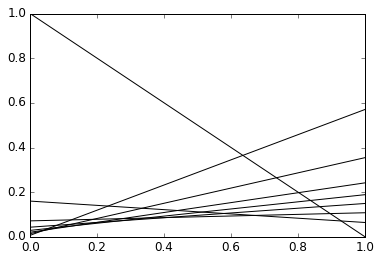

In [107]:
fpr = rslts_knn_hot_uniform['fpr']
tpr = rslts_knn_hot_uniform['tpr']
thr = rslts_knn_hot_uniform['thresh']
plt.figure()
prev_thr = 1.
for fp, tp, th in zip(fpr, tpr, thr):
    if (prev_thr-th) >= 0.:
        x_ax = np.linspace(0,1,10)
        y_ax = (1-tp-fp)*x_ax + fp

        plt.plot(x_ax, y_ax, 'k-', alpha=1)
        prev_thr = th

In [108]:
print tpr[-10:]

[ 0.          0.42956051  0.64539434  0.75827815  0.81125828  0.85069235
  0.89223359  0.935882    1.        ]


In [109]:
def cost_curve(fpr, tpr):
    prev_fp = 0.
    prev_tp = 0.

    p_plus = [0.]
    er = [0.]
    for fp, tp in zip(fpr, tpr):
        delta_fp = fp - prev_fp
        if delta_fp != 0.:
            slp = (tp - prev_tp)/(delta_fp)
            tp_0= prev_tp - slp*prev_fp
            p_plus.append(1./(1.+slp))
            er.append(p_plus[-1]*(1-tp_0))

    p_plus.append(1.)
    er.append(0.)
    return(p_plus, er)

(0, 1)

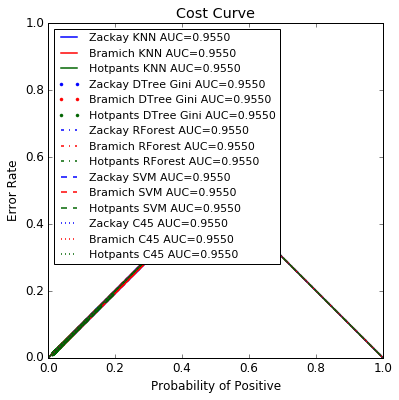

In [110]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sub_methods = [zky, bch, hot]

colors = ['blue', 'red', 'darkgreen']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest],
              'DTree Gini': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform]}


ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(6, 6))
for k, v in ml_methods.iteritems():
    for i in range(3):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        p_plus, er = cost_curve(fpr, tpr)
        
        sub_meth_col.append(roc_auc)
        
        label = sub_meth_col[0]+' '+k+' AUC={:06.4f}'.format(roc_auc)
        plt.plot(p_plus, er, ls[j], lw=1.5, color=colors[i], label=label)
    j+=1

plt.xlabel('Probability of Positive')
plt.ylabel('Error Rate')
plt.legend(loc='upper left', fontsize=11)
plt.title('Cost Curve')

plt.xlim(0, 1)
plt.ylim(0, 1)


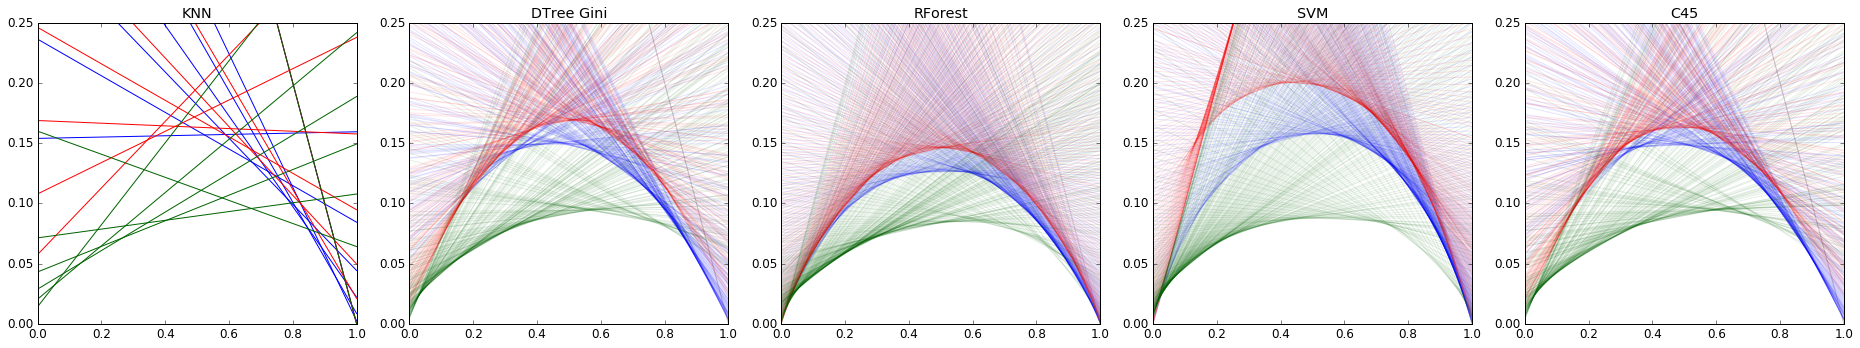

In [111]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sub_methods = [zky, bch, hot]

colors = ['blue', 'red', 'darkgreen']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest],
              'DTree Gini': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform]}


ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(26, 5))
for k, v in ml_methods.iteritems():
    plt.subplot(1, 5, j+1)
    plt.title(k)
    for i in range(3):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        thr = sub_method['thresh']
        prev_thr = 1.
        if k=='KNN':
            alpha = 1
        else: alpha=0.1
        for fp, tp, th in zip(fpr, tpr, thr):
            if (prev_thr-th) >= 0.005:
                x_ax = np.linspace(0,1,10)
                y_ax = (1-tp-fp)*x_ax + fp

                plt.plot(x_ax, y_ax, '-', color=colors[i], alpha=alpha)
                prev_thr = th
    plt.ylim(0, 0.25)
    j+=1
plt.tight_layout()

plt.savefig('cost_without_pca.png')

## With PCA

### K-Nearest Neighbors


**OIS**

In [112]:
rslts_knn_ois_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_ois_t, Y_ois.as_matrix())

**Zackay**

In [113]:
rslts_knn_zps_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [114]:
rslts_knn_hot_uniform = experiment(neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform'),
                                   X_hot_t, Y_hot.as_matrix())

### Support vector machines

**OIS**

In [115]:
rslts_ois_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_ois_t, Y_ois.as_matrix())

**Zackay**

In [116]:
rslts_zps_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [117]:
rslts_hot_svc = experiment(svm.SVC(kernel='linear', 
                                   probability=True, 
                                   cache_size=800, 
                                   class_weight='balanced'),
                           X_hot_t, Y_hot.as_matrix())

### Decision tree (gini)

**OIS**

In [118]:
rslts_ois_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_ois_t, Y_ois.as_matrix())

**Zackay**

In [119]:
rslts_zps_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [120]:
rslts_hot_dtree_gini = experiment(DecisionTreeClassifier(min_samples_leaf=20), X_hot_t, Y_hot.as_matrix())

### Random forest

**OIS**

In [121]:
rslts_ois_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_ois_t, Y_ois.as_matrix())

**Zackay**

In [122]:
rslts_zps_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [123]:
rslts_hot_rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                      min_samples_leaf=20, 
                                                      #max_features=7, 
                                                      n_jobs=7), 
                               X_hot_t, Y_hot.as_matrix())

### DecisionTreeClassifier (C45)

**OIS**

In [124]:
rslts_ois_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_ois_t, Y_ois.as_matrix())

**Zackay**

In [125]:
rslts_zps_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_zps_t, Y_zps.as_matrix())

**Hotpants**

In [126]:
rslts_hot_c45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20), 
                               X_hot_t, Y_hot.as_matrix())

### ROC curve

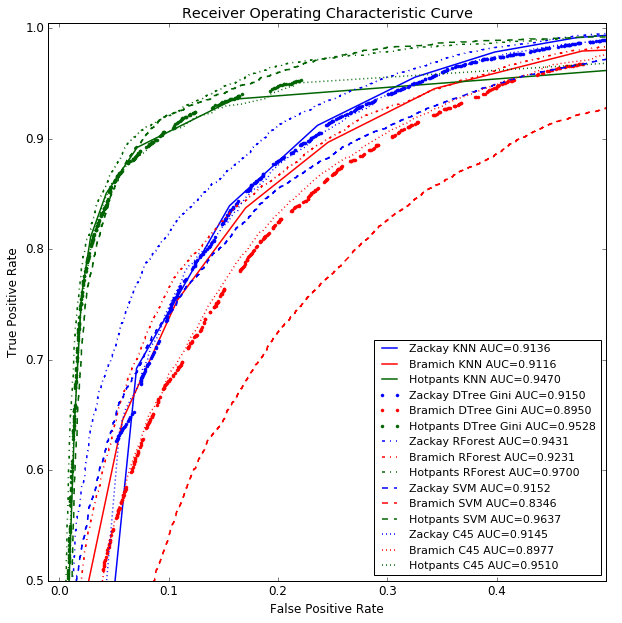

In [127]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sub_methods = [zky, bch, hot]

colors = ['blue', 'red', 'darkgreen']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest],
              'DTree Gini': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform]}


ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(10, 10))
for k, v in ml_methods.iteritems():
    for i in range(3):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        roc_auc = sub_method['roc_auc']
        sub_meth_col.append(roc_auc)
        
        label = sub_meth_col[0]+' '+k+' AUC={:06.4f}'.format(roc_auc)
        plt.plot(fpr, tpr, ls[j], lw=1.5, color=colors[i], label=label)
    j+=1

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=11)
plt.title('Receiver Operating Characteristic Curve')

plt.xlim([-0.01, 0.50])
plt.ylim([0.5, 1.005])
plt.savefig('roc_with_pca.png')

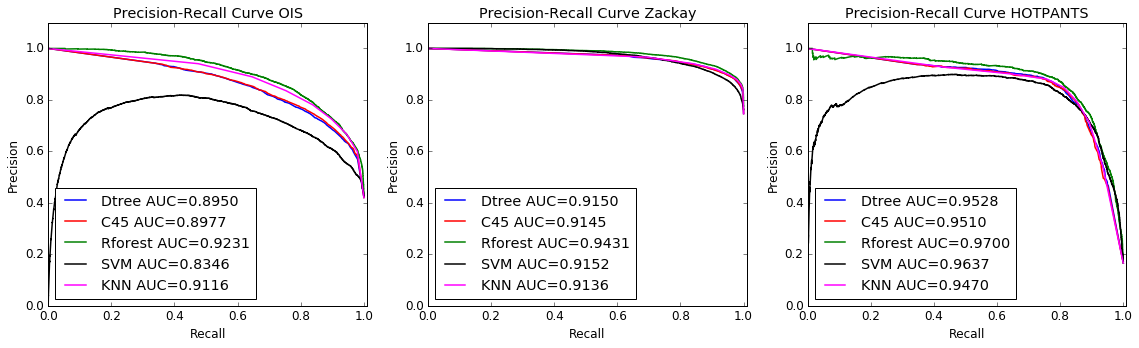

In [128]:
plt.figure(figsize=(16, 5))
#plt.figaspect(.8)
plt.subplot(131)
res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve OIS')

plt.subplot(132)
res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))
0
pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve Zackay')


plt.subplot(133)
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform

pr, rec, thr = res_Dtree['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(res_Dtree['roc_auc']))

pr, rec, thr = res_C45['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(res_C45['roc_auc']))

pr, rec, thr = res_Rforest['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(res_Rforest['roc_auc']))

pr, rec, thr = res_svc['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(res_svc['roc_auc']))

pr, rec, thr = res_knn['prec_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(res_knn['roc_auc']))

plt.xlim(0, 1.01)
plt.ylim(0.0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title('Precision-Recall Curve HOTPANTS')

plt.tight_layout()

plt.savefig('prec_rec_with_pca.png')

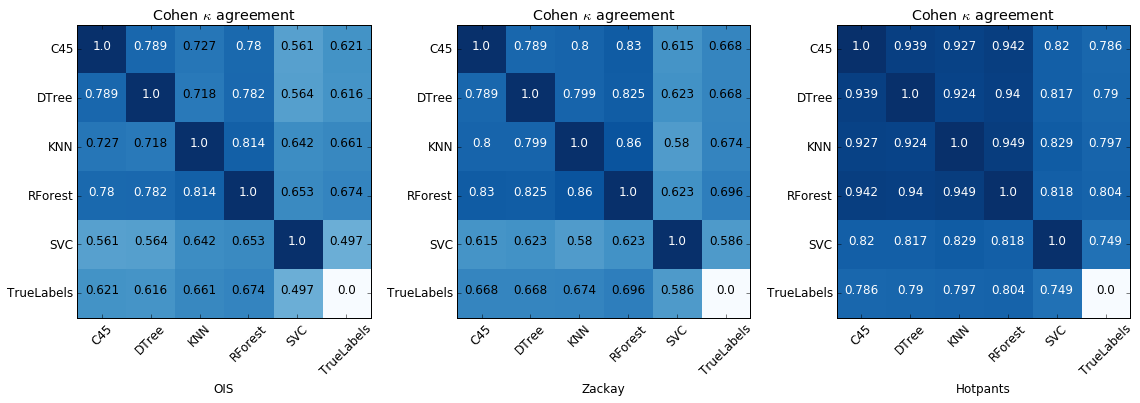

In [129]:
m_coll = []

res_Dtree = rslts_ois_dtree_gini
res_C45 = rslts_ois_c45
res_Rforest = rslts_ois_rforest
res_svc = rslts_ois_svc
res_knn = rslts_knn_ois_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])

res_Dtree = rslts_zps_dtree_gini
res_C45 = rslts_zps_c45
res_Rforest = rslts_zps_rforest
res_svc = rslts_zps_svc
res_knn = rslts_knn_zps_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
 
res_Dtree = rslts_hot_dtree_gini
res_C45 = rslts_hot_c45
res_Rforest = rslts_hot_rforest
res_svc = rslts_hot_svc
res_knn = rslts_knn_hot_uniform
true_labels = {'predictions': res_Rforest['y_test']}

m_coll.append([res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels])
names = ['OIS', 'Zackay', 'Hotpants']

plt.figure(figsize=(16, 6))
for k, methods in enumerate(m_coll):
    kappa_agreement = np.ones((len(methods), len(methods)))

    for i in range(len(methods)):
        for j in range(i+1):
            kappa_agreement[i, j] = metrics.cohen_kappa_score(methods[i]['predictions'],
                                                              methods[j]['predictions'])#, 
                                                              #labels=['star', 'galaxy'])
            kappa_agreement[j, i] = kappa_agreement[i, j]
    kappa_agreement[-1, -1] = 0
    plt.subplot(1, 3, k+1)
    
    plot_confusion_matrix(np.round(kappa_agreement, 3), 
                          classes=['C45', 'DTree', 'KNN', 'RForest', 'SVC', 'TrueLabels'],
                          title=r'Cohen $\kappa$ agreement')
    #plt.tight_layout()
    plt.xlabel(names[k])
    plt.ylabel('')


plt.savefig('cohen_with_pca.png')

In [130]:
aucs = pd.DataFrame([zky, bch, hot], columns=['SubMethod','DTreeGini', 'C45', 'RandomForest', 'KNN', 'SVM'], )

In [131]:
AUCTable = aucs.set_index(['SubMethod'])

In [132]:
AUCTable

,DTreeGini,C45,RandomForest,KNN,SVM
SubMethod,,,,,
Zackay,0.913564,0.914975,0.943084,0.915187,0.914546
Bramich,0.911594,0.894996,0.923073,0.834637,0.897703
Hotpants,0.947040,0.952771,0.969988,0.963724,0.951004


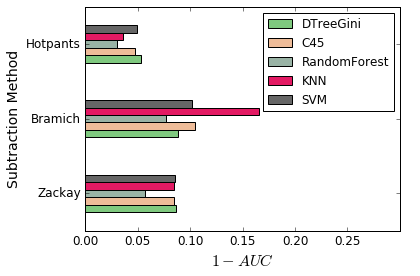

In [133]:
(1-AUCTable).plot.barh(log=False, cmap='Accent')
plt.xlabel(r'$1-AUC$', fontsize=16)
plt.ylabel('Subtraction Method', fontsize=14)
plt.tight_layout()
plt.xlim(0, 0.3)
plt.legend(loc='best', fontsize=12)
plt.savefig('./plots/complementary_AUC2_withPCA.png', dpi=600)

## Cost curves

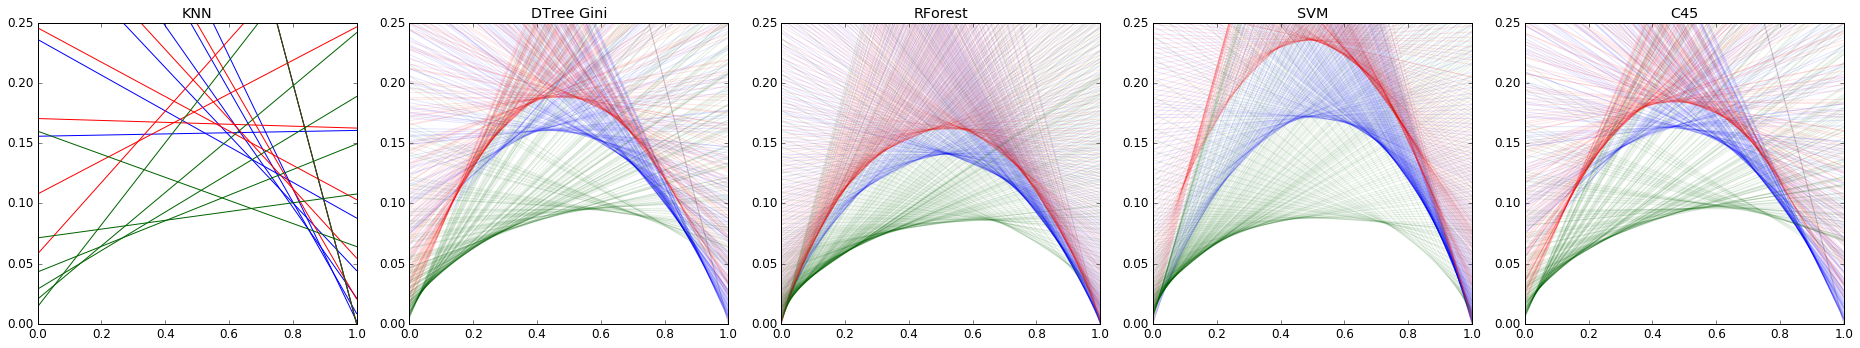

In [138]:
zky = ['Zackay']
bch = ['Bramich']
hot = ['Hotpants']
sub_methods = [zky, bch, hot]

colors = ['blue', 'red', 'darkgreen']

ml_methods = {'RForest'   : [rslts_zps_rforest, rslts_ois_rforest, rslts_hot_rforest],
              'DTree Gini': [rslts_zps_dtree_gini, rslts_ois_dtree_gini, rslts_hot_dtree_gini],
              'C45'       : [rslts_zps_c45, rslts_ois_c45, rslts_hot_c45],
              'SVM'       : [rslts_zps_svc, rslts_ois_svc, rslts_hot_svc], 
              'KNN'       : [rslts_knn_zps_uniform, rslts_knn_ois_uniform, rslts_knn_hot_uniform]}


ls = ['-', '.', '-.', '--', ':']
j = 0
plt.figure(figsize=(26, 5))
for k, v in ml_methods.iteritems():
    plt.subplot(1, 5, j+1)
    plt.title(k)
    for i in range(3):
        sub_method = v[i]
        sub_meth_col = sub_methods[i]
        
        fpr = sub_method['fpr']
        tpr = sub_method['tpr']
        thr = sub_method['thresh']
        prev_thr = 1.
        if k=='KNN':
            alpha = 1
        else: alpha=0.1
        for fp, tp, th in zip(fpr, tpr, thr):
            if (prev_thr-th) >= 0.005:
                x_ax = np.linspace(0,1,10)
                y_ax = (1-tp-fp)*x_ax + fp

                plt.plot(x_ax, y_ax, '-', color=colors[i], alpha=alpha)
                prev_thr = th
    plt.ylim(0, 0.25)
    j+=1
plt.tight_layout()

plt.savefig('cost_with_pca.png')